In [6]:
from itertools import groupby
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import soundfile as sf

##############
# load model & audio and run audio through model
##############
model_name = 'facebook/wav2vec2-large-960h-lv60-self'
processor = Wav2Vec2Processor.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(model_name)

# Detect device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

audio_filepath = r"C:/Users/stell/OneDrive/desktop/CANS_LAB/Female_Single_Speakers/F01_single105.wav"
speech, sample_rate = sf.read(audio_filepath)
input_values = processor(speech, sampling_rate=16000, return_tensors="pt").input_values.to(device)

with torch.no_grad():
    logits = model(input_values).logits

predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.decode(predicted_ids[0]).lower()

##############
# this is where the logic starts to get the start and end timestamp for each word
##############
words = [w for w in transcription.split(' ') if len(w) > 0]
predicted_ids = predicted_ids[0].tolist()
duration_sec = input_values.shape[1] / sample_rate


ids_w_time = [(i / len(predicted_ids) * duration_sec, _id) for i, _id in enumerate(predicted_ids)]
# remove entries which are just "padding" (i.e. no characers are recognized)
ids_w_time = [i for i in ids_w_time if i[1] != processor.tokenizer.pad_token_id]
# now split the ids into groups of ids where each group represents a word
split_ids_w_time = [list(group) for k, group
                    in groupby(ids_w_time, lambda x: x[1] == processor.tokenizer.word_delimiter_token_id)
                    if not k]

assert len(split_ids_w_time) == len(words)  # make sure that there are the same number of id-groups as words. Otherwise something is wrong

word_start_times = []
word_end_times = []
# for cur_ids_w_time, cur_word in zip(split_ids_w_time, words):
#     _times = [_time for _time, _id in cur_ids_w_time]
#     word
#     word_start_times.append(min(_times))
#     word_end_times.append(max(_times))
    
# words, word_start_times, word_end_times

word_data = []
for word, start, end in zip(words, word_start_times, word_end_times):
    word_data.append({
        'start': round(start, 3),
        'end': round(end, 3),
        'word': word
    })

for entry in word_data:
    print(f"{entry['start']:.3f}\t{entry['end']:.3f}\t{entry['word']}")


Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60-self and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
import pandas as pd
import os

# Creating dataframes
df_word_wav2vec2 = pd.DataFrame(word_data)

df_word_wav2vec2.to_csv('Wav2vec2_timings.csv', index = False, float_format="%.7f")

output_path = 'compare_timings.csv'
if not os.path.exists(output_path):
    # Read MFA CSV
    df_wav2vec2 = pd.read_csv('Wav2vec2_timings.csv')
    
    #Read all CSV for comparison
    df_total = pd.read_csv(r"C:\Users\stell\OneDrive\Desktop\CANS_LAB\compare_timings.csv")
    
    combined_timings = pd.concat([df_total, df_wav2vec2], axis=1)
    
    combined_timings.to_csv(output_path, index=False, float_format="%.7f")

else:
    print("Output file already exists. Skipping concatenation.")

Output file already exists. Skipping concatenation.


Text(0, 0.5, 'Frequency')

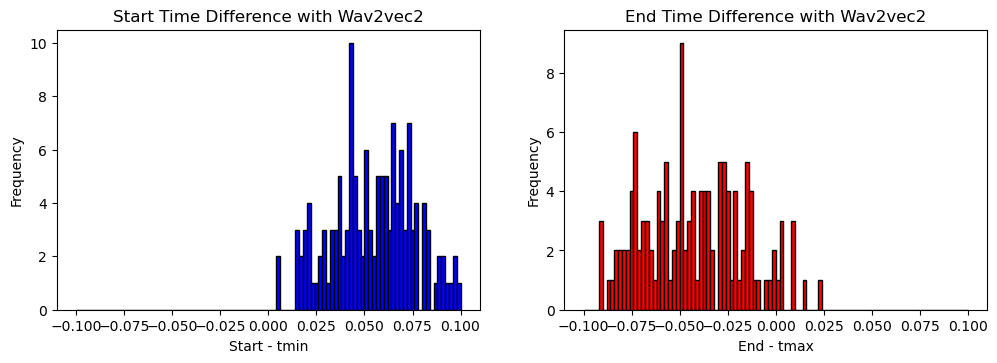

In [11]:
import matplotlib.pyplot as plt

df_total_total = pd.read_csv('compare_timings.csv')
#Read combined timings
#Get the differences
combined_df_start = df_total_total["start"] - df_total_total["tmin"]
#print("start difference\n",combined_df_start)

combined_df_end =  df_total_total["end"] - df_total_total["tmax"]
#print("End difference\n", combined_df_end)


plt.figure(figsize=(12, 8))

# Histogram of Start difference
plt.subplot(2, 2, 1)
plt.hist(combined_df_start, bins = 100, color='blue', edgecolor='black', range=(-0.1, 0.1))
plt.title("Start Time Difference with Wav2vec2")
plt.xlabel("Start - tmin")
plt.ylabel("Frequency")

# Histogram of End difference
plt.subplot(2, 2, 2)
plt.hist(combined_df_end, bins = 100, color='red', edgecolor='black', range=(-0.1, 0.1))
plt.title("End Time Difference with Wav2vec2")
plt.xlabel("End - tmax")
plt.ylabel("Frequency")